In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Attention
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [2]:
import numpy as np
print(np.__version__)

1.24.4


In [1]:
import tensorflow as tf
print(tf.__version__)


TypeError: bases must be types

In [2]:
# Step 1: Load Data
data = pd.read_csv(r'../data/keypoints_output_with_filename.csv')

# Step 2: Preprocess Data
# Remove 'fall' from 'image_fall_num' and convert to integer
data['image_fall_num'] = data['image_fall_num'].str.replace('fall', '').astype(int)

# Sort and group by 'image_fall_num'
data = data.sort_values(by=['image_fall_num', 'image_num'])  # Assume 'frame_index' indicates temporal order
groups = data.groupby('image_fall_num')

# Extract sequences and labels
sequences = []
labels = []
for _, group in groups:
    # Select only numeric columns and handle non-numeric values
    numeric_data = group.iloc[:, 2:-1].apply(pd.to_numeric, errors='coerce')  # Convert to numeric, NaN if not possible
    numeric_data = numeric_data.fillna(0)  # Replace NaN with 0 or another strategy
    sequences.append(numeric_data.values)
    
    # Store all labels in the group instead of just one
    labels.extend(group['label'].values)  # Append all labels from the group

# Padding sequences to the same length
max_seq_length = max(len(seq) for seq in sequences)
num_features = sequences[0].shape[1]

padded_sequences = np.zeros((len(labels), max_seq_length, num_features))
label_array = np.array(labels, dtype=int)

idx = 0
for i, seq in enumerate(sequences):
    for _ in range(len(seq)):
        padded_sequences[idx, :len(seq), :] = seq
        idx += 1

# Ensure at least two classes before applying SMOTE
if len(np.unique(label_array)) < 2:
    minority_class = 1 if 1 in label_array else 2
    label_array = np.concatenate([label_array, np.full(5, minority_class)])  # Add missing class

# Check class distribution before SMOTE
print("Original class distribution:", np.unique(label_array, return_counts=True))

# Normalize the sequences
scaler = MinMaxScaler()
num_samples, seq_length, num_features = padded_sequences.shape
reshaped_sequences = padded_sequences.reshape(-1, num_features)
norm_sequences = scaler.fit_transform(reshaped_sequences)
norm_sequences = norm_sequences.reshape(num_samples, seq_length, num_features)

# Apply SMOTE BEFORE train-test split
unique_classes = np.unique(label_array)
if len(unique_classes) > 1:
    smote = SMOTE(sampling_strategy={1: 4000}, random_state=42)
    norm_sequences_reshaped = norm_sequences.reshape(num_samples, -1)  # 2D 변환
    norm_sequences_resampled, labels_resampled = smote.fit_resample(norm_sequences_reshaped, label_array)
    # Reshape back to 3D
    num_samples_resampled = norm_sequences_resampled.shape[0]
    norm_sequences_resampled = norm_sequences_resampled.reshape(num_samples_resampled, max_seq_length, num_features)
    print("SMOTE applied.")
else:
    print("SMOTE not applied as only one class is present in dataset")
    norm_sequences_resampled, labels_resampled = norm_sequences, label_array

# Train-test split AFTER SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    norm_sequences_resampled, labels_resampled, test_size=0.2, random_state=42, stratify=labels_resampled
)

# Check class distribution in training data
print("Training class distribution:", np.unique(y_train, return_counts=True))

# Data Augmentation: Add Time Noise

def add_time_noise(data, noise_level=0.05):
    noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
    return data + noise

X_train = np.array([add_time_noise(seq) for seq in X_train])
print("Time noise added for data augmentation.")

# Convert labels back to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Step 3: Define the Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(max_seq_length, num_features))),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

# Step 5: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Save the model
model.save('fall_detection_model.keras')


Original class distribution: (array([0, 1, 2]), array([8073,  837, 4894]))
SMOTE applied.
Training class distribution: (array([0, 1, 2]), array([6458, 3200, 3915]))
Time noise added for data augmentation.
Epoch 1/50
170/170 [==============================] - 79s 447ms/step - loss: 1.0442 - accuracy: 0.4655 - val_loss: 1.0107 - val_accuracy: 0.5193
Epoch 2/50
170/170 [==============================] - 68s 399ms/step - loss: 1.0129 - accuracy: 0.4968 - val_loss: 1.1044 - val_accuracy: 0.4843
Epoch 3/50
170/170 [==============================] - 67s 395ms/step - loss: 1.0046 - accuracy: 0.5077 - val_loss: 0.9941 - val_accuracy: 0.5160
Epoch 4/50
170/170 [==============================] - 68s 403ms/step - loss: 0.9883 - accuracy: 0.5287 - val_loss: 0.9816 - val_accuracy: 0.5197
Epoch 5/50
170/170 [==============================] - 69s 407ms/step - loss: 0.9706 - accuracy: 0.5367 - val_loss: 0.9645 - val_accuracy: 0.5252
Epoch 6/50
170/170 [==============================] - 70s 411ms/step -

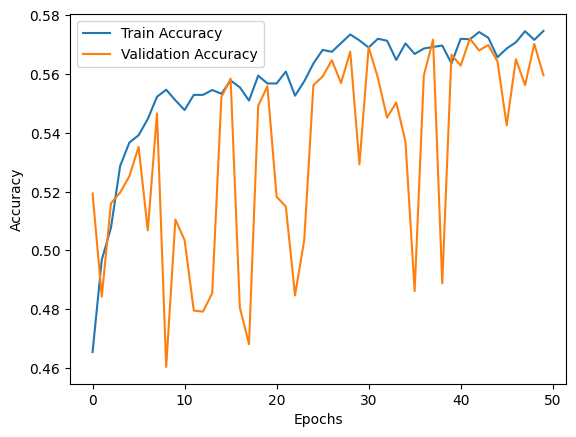

In [5]:
import matplotlib.pyplot as plt

# 학습 곡선 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
!pip install seaborn

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load Data
data = pd.read_csv(r'../data/keypoints_output_with_filename.csv')
data['image_fall_num'] = data['image_fall_num'].str.replace('fall', '').astype(int)
data = data.sort_values(by=['image_fall_num', 'image_num'])
groups = data.groupby('image_fall_num')

# Extract sequences and labels
sequences = []
labels = []
for _, group in groups:
    numeric_data = group.iloc[:, 2:-1].apply(pd.to_numeric, errors='coerce').fillna(0)
    sequences.append(numeric_data.values)
    labels.extend(group['label'].values)

# Padding sequences
max_seq_length = max(len(seq) for seq in sequences)
num_features = sequences[0].shape[1]
padded_sequences = np.zeros((len(labels), max_seq_length, num_features))
label_array = np.array(labels, dtype=int)

idx = 0
for i, seq in enumerate(sequences):
    for _ in range(len(seq)):
        padded_sequences[idx, :len(seq), :] = seq
        idx += 1

# Normalize the sequences
scaler = StandardScaler()
num_samples, seq_length, num_features = padded_sequences.shape
reshaped_sequences = padded_sequences.reshape(-1, num_features)
norm_sequences = scaler.fit_transform(reshaped_sequences)
norm_sequences = norm_sequences.reshape(num_samples, seq_length, num_features)

# Apply RandomOverSampler BEFORE train-test split
ros = RandomOverSampler(random_state=42)
norm_sequences_reshaped = norm_sequences.reshape(num_samples, -1)
norm_sequences_resampled, labels_resampled = ros.fit_resample(norm_sequences_reshaped, label_array)
norm_sequences_resampled = norm_sequences_resampled.reshape(len(labels_resampled), max_seq_length, num_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    norm_sequences_resampled, labels_resampled, test_size=0.2, random_state=42, stratify=labels_resampled
)

# Data Augmentation: Add Time Noise
def add_time_noise(data, noise_level=0.05):
    noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
    return data + noise

num_noisy_samples = int(len(X_train) * 0.5)
X_train[:num_noisy_samples] = np.array([add_time_noise(seq) for seq in X_train[:num_noisy_samples]])

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Validate Data Types
print(f"X_train type: {X_train.dtype}, y_train type: {y_train.dtype}")

# Step 3: Define the Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(max_seq_length, num_features)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# 학습률 스케줄 적용
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)

# AdamW 옵티마이저 설정 (legacy가 아닌 tensorflow.keras.optimizers에서 바로 사용)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

# 모델 다시 컴파일
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Confirm the loss function is passed correctly
print(f"Model compiled with loss: categorical_crossentropy")




# Confirm the loss function is passed correctly
print(f"Model compiled with loss: categorical_crossentropy")

# Step 4: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

# Step 5: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Save the model
model.save('fall_detection_model_1.keras')


X_train type: float64, y_train type: float32


Model compiled with loss: categorical_crossentropy
Model compiled with loss: categorical_crossentropy
Epoch 1/100


AttributeError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/fakenews/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/fakenews/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/fakenews/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/fakenews/lib/python3.8/site-packages/keras/src/engine/training.py", line 1084, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)

    AttributeError: 'str' object has no attribute 'minimize'


In [9]:
print("Optimizer type:", type(optimizer))

Optimizer type: <class 'keras.src.optimizers.adamw.AdamW'>
